<a href="https://colab.research.google.com/github/RuslanMavlitov/IDE/blob/master/S_T_learners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> S-learner, T-learner. Принципы работы. Практика

Итак, давайте поработаем с S- и T- learner`ами: вручную и с помощью библиотек [scikit-uplift](https://github.com/maks-sh/scikit-uplift) (sklift) и [CausalML](https://github.com/uber/causalml).


Для начала установим необходимые библиотеки:

In [34]:
#!pip install scikit-uplift  
#!pip install catboost
!pip install causalml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
#!git clone https://github.com/uber/causalml.git
#!cd causalml
!pip install -r /content/causalml/requirements.txt
!pip install causalml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Импортируем необходимые библиотеки и загрузим семпл данных

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Импортируем S- и T- learner`ы  (SoloModel и TwoModels) из библиотеки scikit-uplift (sklift)
from sklift.models import SoloModel, TwoModels

# Импортируем S- и T-learner`ы (BaseSClassifier и BaseTClassifier) из библиотеки CausalML
# Нам нужны именно Classifier, так как мы будем решать задачу классификации
# Аналогичные реализации (Regressor) есть и для задач регрессии
from causalml.inference.meta import BaseSClassifier, BaseTClassifier


# В качестве классификатора воспользуемся моделью градиентного бустинга от Яндекса (CatBoost)
from catboost import CatBoostClassifier

# Прочитаем файл с данными
df = pd.read_csv("/content/data.csv")
df.head()

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target_class
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,2
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,2
3,9,675.83,1,0,Rural,1,Web,Discount,2
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,2


**Справка о признаках:**
* **recency** - количество месяцев с последней покупки клиента
* **history** - общая стоимость исторических покупок
* **used_discount** - указывает, пользовался ли клиент скидкой ранее
* **used_bogo** - указывает, пользовался ли клиент промоакцией ранее
* **zip_code** - класс почтового индекса:
    * Suburban - пригородный
    * Urban - городской
    * Rural - сельский
* **is_referral** - указывает, был ли клиент приобретен по реферальному каналу
* **channel** - каналы, которые использует клиент:
    * Phone - телефон
    * Web - интернет
    * Multichannel - многоканальный
* **treatment** - вид целевого воздействия:
    * **Discount** - было оказано целевое воздействие (предложена скидка)
    * **Buy One Get One** - было оказано целевое воздействие (предложена промоакция)
    * **No Offer** - целевого воздействие не было
* **target_class** - класс клиента (вспомогательный признак):
    * **0 - Control Non-Responders(CN)** 

        Это клиенты, которым не было выдвинуто предложение (целевое воздействие) и они ничего не купили ((y=0, c) в наших терминах)
    * **1 - Control Responders(CR)**

        Это клиенты, совершившие покупку без предложения (целевого воздействия) (y=1, c)
    * **2 - Treatment Non-Responders(CN)**

        Это клиенты, которым было выдвинуто предложение, но они не совершили покупку (y=0, t)
    * **3 - Treatment Responders(CN)** 
        
        Это клиенты, которым было выдвинуто предложение (совершено целевое воздействие) и они совершили покупку (y=1, t)

При построении классификатора нас интересует только факт того, совершил ли клиент покупку (класс 1) или нет (класс 0). Поэтому целевая переменная при классификации - конверсия. 

Посмотрим на распределение целевых влияний в данных:

* Discount - было оказано целевое влияние (предложена скидка)
* Buy One Get One - было оказано целевое влияние (предложена промоакция)
* No Offer - целевого влияния не было

In [2]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

## Предобработка данных

Подготовим данные:
* Преобразуем целевую переменную в признак конверсии, которую будем прогнозировать (купил/не купил)
* Создадим две отдельные таблицы:
    * В первой будем хранить информацию о пользователях, которым была предложена скидка (df_discount)
    * Во второй будем хранить информацию о пользователях, которым была предложена промоакция (df_bogo)
    
    В каждой из таблиц также сохраним данные о пользователях, на которых не было оказано целевое влияние (контрольная выборка).
* Также произведем кодировку категориальных признаков.

In [3]:
# Новый таргет - бинарная переменная (конверсия): 1 - купил, 0 - не купил
df['conversion'] = df['target_class'].map({0: 0, 1: 1, 2: 0, 3: 1})

# Разделим данные на две таблицы - данные по скидкам и промоакциям

# Выделим пользователей, на которых не было целевого воздействия, и тех, которым мы предлагали скидки
df_discount = df.copy().loc[
    (df['treatment'] == 'No Offer') |  (df['treatment'] == 'Discount')
].reset_index(drop=True)

# Выделим пользователей, на которых не было целевого воздействия, и тех, которым мы предлагали промоакции
df_bogo = df.copy().loc[
    (df['treatment'] == 'No Offer') | (df['treatment'] == 'Buy One Get One')
].reset_index(drop=True)

# Перекодируем столбец с влиянием: 1 - было влияние, 0 - не было
df_discount['treatment'] = df_discount['treatment'].apply(lambda x: 0 if x=='No Offer' else 1)
df_bogo['treatment'] = df_bogo['treatment'].apply(lambda x: 0 if x=='No Offer' else 1)

# Закодируем оставшиеся категориальные признаки
df_discount = pd.get_dummies(df_discount)
df_bogo = pd.get_dummies(df_bogo)

# Выведем размерности полученных таблиц:
print(df_discount.shape)
print(df_bogo.shape)

(42613, 14)
(42693, 14)


Посмотрим на результаты:

In [4]:
df_discount.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,6,329.08,1,1,1,0,0,0,1,0,0,0,0,1
1,9,675.83,1,0,1,1,2,0,1,0,0,0,0,1
2,9,675.07,1,1,1,1,2,0,1,0,0,0,1,0
3,2,101.64,0,1,0,1,3,1,0,0,1,0,0,1
4,4,241.42,0,1,1,0,0,0,1,0,0,1,0,0


In [5]:
df_bogo.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,2,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,2,0,0,1,0,0,0,1
3,2,45.34,1,0,0,1,2,0,0,0,1,0,0,1
4,6,134.83,0,1,0,1,3,1,0,1,0,0,1,0


In [6]:
# Определим колонки с факторами, тритментом и таргетом
feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']

target_col = 'conversion'
treatment_col = 'treatment'

## Работаем с данными о скидках

### Обучающая и тестовая выборка

Мы будем работать с данными о скидках. Оценить uplift-эффект на данных о результатх промоакций вам предстоит самостоятельно.

Разделим данные на тренировочную и тестовую выборки.

In [7]:
df_discount_train, df_discount_test = train_test_split(
    df_discount, 
    stratify=df_discount[[treatment_col, target_col]], 
    random_state=13, 
    test_size=0.3
)
print(df_discount_train.shape)
print(df_discount_test.shape)

df_discount_train.head()

(29829, 14)
(12784, 14)


,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
28236,1,616.27,1,0,1,1,2,0,0,0,1,1,0,0
37748,11,158.76,0,1,1,0,0,0,0,0,1,0,0,1
41505,3,269.60,1,0,1,1,2,0,0,0,1,0,1,0
1595,3,458.76,1,0,0,1,2,0,1,0,0,1,0,0
31544,7,209.56,0,1,0,1,2,0,0,0,1,1,0,0


### Quni-curve и qini-score

Создадим функцию для построения qini-curve и расчета qini-score.

In [8]:
# Возьмем функцию для оценки qini-curve с прошлого занятия
def qini_df(df, title='train', figsize=(5, 3)):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    
    # Немного кода для визуализации
    fig = plt.figure(figsize=figsize)
    plt.plot(ranked['n'], ranked['uplift'], color='r', label='Model')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b', label='RandomModel')
    plt.legend()
    plt.title('Qini-curve for {} samples'.format(title))
    plt.show()
    quni_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    print('Qini score: {:.3f}'.format(quni_score))

## Uplift-моделирование с помощью scikit-uplift

В этом разделе мы с вами применим реализацию S-learner и T-learner из библиотеки [scikit-uplift](https://github.com/maks-sh/scikit-uplift), а также реализуем эти модели вручную и сравним результаты.

**Примечание:**

Результаты uplift-моделирования могут незначительно отличаться в зависимости от версии библиотек. Будьте внимательны.


### S-learner (scikit-uplift)

Давайте по нашим данным построим S-learner из библиотеки scikit-uplift ([документация](https://www.uplift-modeling.com/en/latest/index.html)). В качестве классификатора возьмем реализацию градиентного бустинга от Яндекса (CatBoost). 

Обучим S-learner из библиотеки sklift ([SoloModel](https://www.uplift-modeling.com/en/latest/api/models/SoloModel.html)), сделаем предсказание uplift на тренировочной и тестовой выборках и оценим качество uplift-моделирования с помощью qini-curve и qini-score.



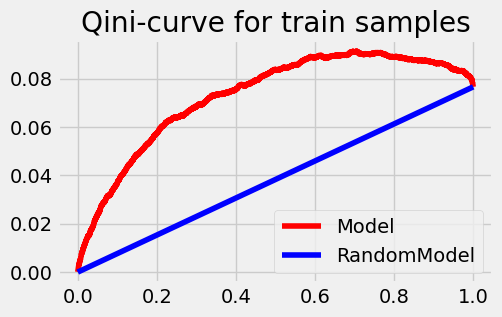

Qini score: 1016.862


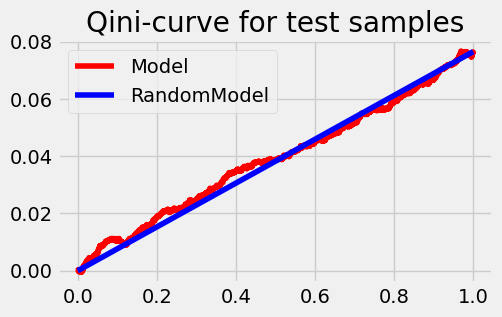

Qini score: 9.216


In [9]:
# Создаем базовый S-learner
s_learner = SoloModel(
    estimator=CatBoostClassifier(random_seed=13, verbose=0)
)

# Для обучения нам нужны датафрем с факторами, таргет и колонка с фактом воздействия
s_learner = s_learner.fit(
    X=df_discount_train[feature_cols],
    y=df_discount_train[target_col],
    treatment=df_discount_train[treatment_col]
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(df_discount_train[feature_cols])
df_discount_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(df_discount_test[feature_cols])
df_discount_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_discount_train, title='train')
qini_df(df_discount_test, title='test')

Из результатов моделирования мы видим, что модель CatBoost оказалась сильно переобученной. 

Давайте попробуем воспользоваться более простой моделью. В качестве классификатора возьмем логистическую регрессию.

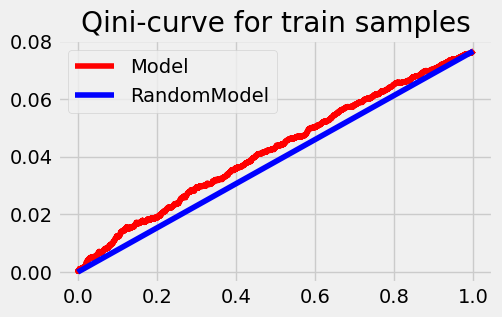

Qini score: 115.988


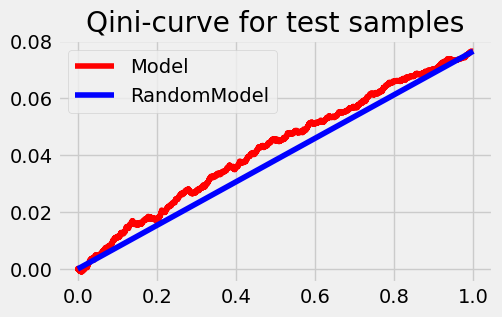

Qini score: 50.879


In [10]:
# Создаем базовый S-learner
s_learner = SoloModel(estimator=LogisticRegression(max_iter=10000))

# Для обучения нам нужны датафрем с факторами, таргет и колонка с фактом воздействия
s_learner = s_learner.fit(
    X=df_discount_train[feature_cols],
    y=df_discount_train[target_col],
    treatment=df_discount_train[treatment_col]
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(df_discount_train[feature_cols])
df_discount_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(df_discount_test[feature_cols])
df_discount_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_discount_train)
qini_df(df_discount_test,  title='test')

Видим, что результат улучшился, разбор модели (переобучение) удалось уменьшить и тем самым повысить качество на тестовой выборке. 

Ну что же,  базовый S-learner довольно неплохо справляется в данном случае. Чуть позже мы попробуем на этом датасете более продвинутые алгоритмы и сравним подходы.

А сейчас давайте, в качестве упраждения создадим S-learner собственным руками и сравним результат с результатом библиотечной версии.

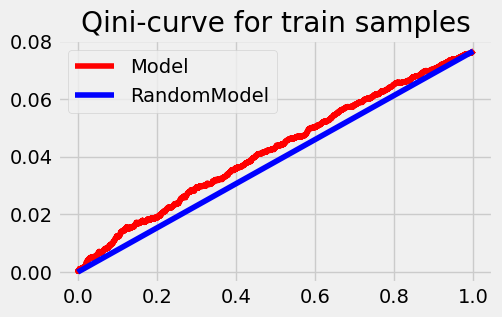

Qini score: 115.988


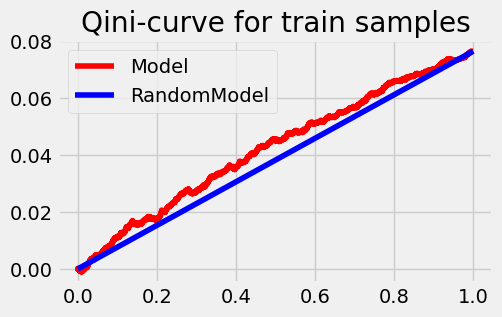

Qini score: 50.879


In [11]:
# Реализуем функцию, рассчитывающих uplift
def compute_s_uplift(ctb_clf, X):
    # Выставляем целевое влияние в 1 (есть воздействие) для всех наблюдений
    X[treatment_col] = 1
    # Предсказываем вероятность покупки при воздействии
    predict_treatment = ctb_clf.predict_proba(X[feature_cols + [treatment_col]])[:, 1]
    # Выставляем целевое влияние в 0 (нет воздействия) для всех наблюдений
    X[treatment_col] = 0
    # Предсказываем вероятность покупки при отсутвии воздействия
    predict_control = ctb_clf.predict_proba(X[feature_cols + [treatment_col]])[:, 1]
    # Рассчитываем uplift-эффекты по формуле
    uplift = predict_treatment - predict_control
    # Возвращаем результат
    return uplift

# Создадим классификатор
ctb_clf = LogisticRegression(max_iter=10000)

# Обучим его на тренировочных данных (важно: в данных должен присутствовать признак целевого влияния)
ctb_clf.fit(df_discount_train[feature_cols + [treatment_col]], df_discount_train[target_col])

# Оценим uplift-эффекты на тестовых данных
df_discount_train['uplift_score'] = compute_s_uplift(ctb_clf, df_discount_train.copy())
qini_df(df_discount_train)

# Оценим uplift-эффекты на тестовых данных
df_discount_test['uplift_score'] = compute_s_uplift(ctb_clf, df_discount_test.copy())
qini_df(df_discount_test)

Мы создали собственный S-learner и его результаты совпали с библиотечным, а значим мы сделали все правильно!

### T-learner (scikit-uplift)

Теперь давайте применим T-learner из библиотеки scikit-uplift. Реализация данного подхода содержится в классе [TwoModel](https://www.uplift-modeling.com/en/latest/api/models/TwoModels.html).

В качестве классификаторов в T-learner воспользуемся CatBoost. 

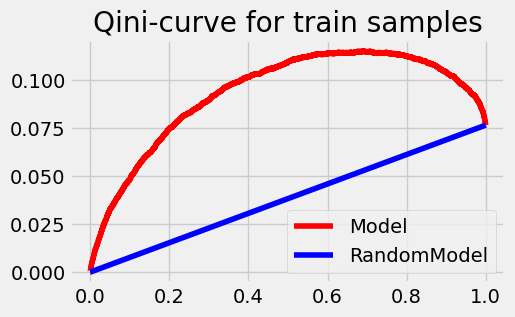

Qini score: 1606.730


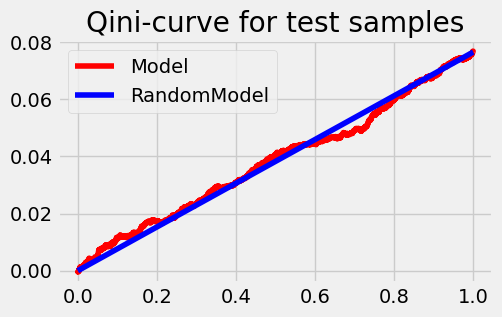

Qini score: 2.322


In [12]:
# Создадим базовый T-learner
t_learner = TwoModels(
    estimator_trmnt=CatBoostClassifier(random_seed=13, verbose=0),
    estimator_ctrl=CatBoostClassifier(random_seed=13, verbose=0)
)

# Для обучения нам нужны датафрем с факторами, таргет и колонка с фактом воздействия
t_learner = t_learner.fit(
    X=df_discount_train[feature_cols],
    y=df_discount_train[target_col],
    treatment=df_discount_train[treatment_col]
)

# Сделаем предсказание uplift-эффекта
uplift_vals = t_learner.predict(df_discount_train[feature_cols])
df_discount_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта
uplift_vals = t_learner.predict(df_discount_test[feature_cols])
df_discount_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_discount_train, title='train')
qini_df(df_discount_test, title='test')

Видим, что результаты T-learner несколько хуже, чем результаты S-learner. 

Не стоит расстраиваться и удивляться, результаты значительно зависят от данных и используемых классификаторов.

Давайте, попробуем обучить T-learner своими руками

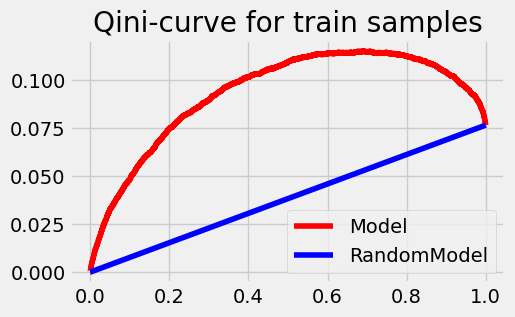

Qini score: 1606.730


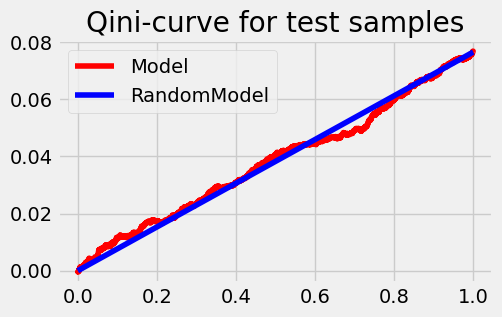

Qini score: 2.322


In [13]:
# Создадим классификаторы
ctb_clf_tr = CatBoostClassifier(random_seed=13, verbose=0)
ctb_clf_ctrl = CatBoostClassifier(random_seed=13, verbose=0)

#Обучим их на исходных данных
unique_treatment = df_discount_train[treatment_col].unique()

ctb_clf_tr.fit(
    X=df_discount_train[df_discount_train[treatment_col] == 1][feature_cols], 
    y=df_discount_train[df_discount_train[treatment_col] == 1][target_col]
)
ctb_clf_ctrl.fit(
    X=df_discount_train[df_discount_train[treatment_col] == 0][feature_cols], 
    y=df_discount_train[df_discount_train[treatment_col] == 0][target_col]
)

# Опишем метод, рассчитывающих аплифт
def compute_t_uplift(ctb_clf_tr, ctb_clf_ctrl, X):
    X[treatment_col] = 1
    predict_treatment = ctb_clf_tr.predict_proba(X[feature_cols + [treatment_col]])[:, 1]
    
    X[treatment_col] = 0
    predict_control = ctb_clf_ctrl.predict_proba(X[feature_cols + [treatment_col]])[:, 1]
    
    uplift = predict_treatment - predict_control
    return uplift

# Оценим uplift эффекты
df_discount_train['uplift_score'] = compute_t_uplift(ctb_clf_tr, ctb_clf_ctrl, df_discount_train.copy())
df_discount_test['uplift_score'] = compute_t_uplift(ctb_clf_tr, ctb_clf_ctrl, df_discount_test.copy())

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_discount_train, title='train')
qini_df(df_discount_test, title='test')

Мы построили собственный T-learner и его результаты совпали с библиотечной реализацией. 

Итак, что мы видим? На текущей задаче S- и T- learner`ы работают не так хорошо, как хотелось бы. 

Посмотрим в дальнейшем как справятся X- и R- learner`ы.

## Uplift-моделирование (CausalML)

Давайте посмотрим на реализацию S-learner и T-learner из библиотеки [CausalML](https://github.com/uber/causalml) от компании Uber ([документация](https://causalml.readthedocs.io/en/latest/index.html)).

### S-learner (CausalML)

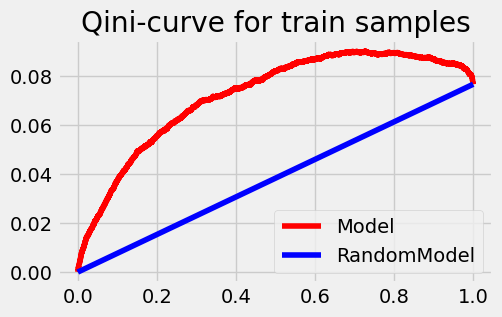

Qini score: 992.267


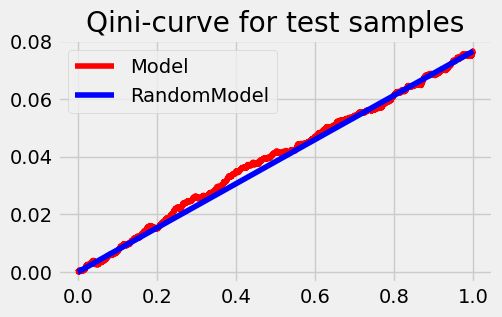

Qini score: 12.124


In [14]:
# Давайте по данным построим S-learner

# Создадим базовый S-learner
s_learner = BaseSClassifier(learner=CatBoostClassifier(random_seed=13, verbose=0))

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
s_learner.fit(X=df_discount_train[feature_cols],
              treatment=df_discount_train[treatment_col],
              y=df_discount_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(np.array(df_discount_train[feature_cols].values.copy()))
df_discount_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(np.array(df_discount_test[feature_cols].values.copy()))
df_discount_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_discount_train, title='train')
qini_df(df_discount_test, title='test')

**Примечание:**

Обратите внимание, что из-за того, что реализация S-learner в CausalML несколько отличается от классической, которая приведена в библиотеке scikit-uplift, результаты моделирования несколько отличаются. Подробнее о реализации S-learner в CausalML вы можете узнать из документации.

### T-learner (CausalML)

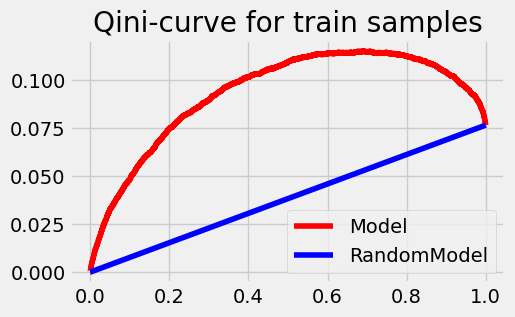

Qini score: 1606.730


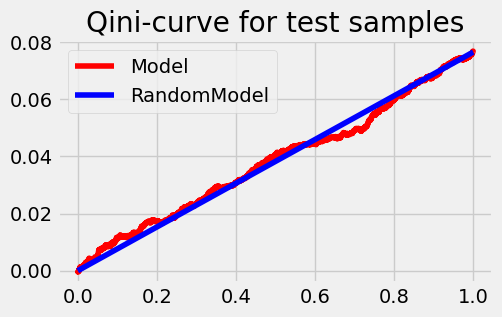

Qini score: 2.322


In [15]:
# Давайте по данным построим T-learner

# Создадим базовый T-learner
t_learner = BaseTClassifier(learner=CatBoostClassifier(random_seed=13, verbose=0))

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
t_learner.fit(X=df_discount_train[feature_cols],
              treatment=df_discount_train[treatment_col],
              y=df_discount_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = t_learner.predict(np.array(df_discount_train[feature_cols].values.copy()))
df_discount_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = t_learner.predict(np.array(df_discount_test[feature_cols].values.copy()))
df_discount_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_discount_train, title='train')
qini_df(df_discount_test, title='test')

## Работаем с данными о промоакциях 

Теперь вам предстоит самостоятельно провести uplift-моделирование на данных о промоакциях. 

### Обучающая и тестовая выборки

Разделим данные на тренировочную и тестовую выборки.

In [16]:
df_bogo_train, df_bogo_test = train_test_split(
    df_bogo, 
    stratify=df_bogo[[treatment_col, target_col]], 
    random_state=13, 
    test_size=0.3
)
print(df_bogo_train.shape)
print(df_bogo_test.shape)

df_bogo_train.head()

(29885, 14)
(12808, 14)


,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
20518,2,167.94,1,0,1,1,2,0,0,1,0,0,0,1
34388,11,129.29,1,0,0,1,2,0,0,1,0,0,1,0
40663,9,129.61,0,1,1,0,0,0,1,0,0,0,0,1
30626,2,333.87,1,0,1,1,2,0,0,1,0,1,0,0
16372,4,103.79,1,0,1,1,2,0,0,0,1,0,0,1


### S-learner (CausalML)

**Задание №1**

Давайте проведем uplift-моделирование на датасете с промо-акциями (df_bogo) с помощью S-learner из библиотеки `CausalML` (BaseSClassifier) качестве классификатора (learner) используйте алгоритм CatBoostClassifier с параметрами по умолчанию. Параметр random_state установите в значение 13. 

Рассчитайте qini-score на тестовой выборке для полученного S-learner. Запишите полученный результат с точностью до 3-его знака после запятой. 

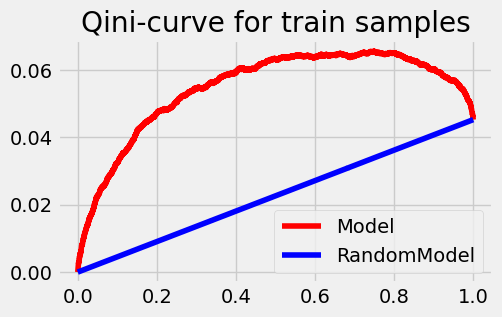

Qini score: 942.527


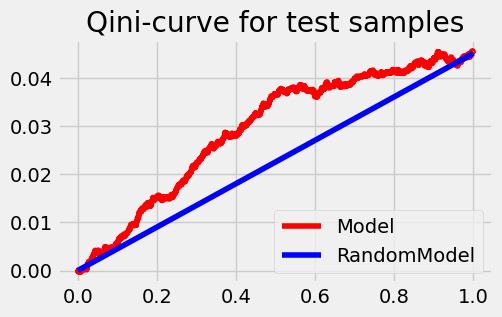

Qini score: 85.840


In [17]:
# Давайте по данным построим S-learner

# Создадим базовый S-learner
s_learner = BaseSClassifier(learner=CatBoostClassifier(random_seed=13, verbose=0))

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
s_learner.fit(X=df_bogo_train[feature_cols],
              treatment=df_bogo_train[treatment_col],
              y=df_bogo_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(np.array(df_bogo_train[feature_cols].values.copy()))
df_bogo_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(np.array(df_bogo_test[feature_cols].values.copy()))
df_bogo_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_bogo_train, title='train')
qini_df(df_bogo_test, title='test')

### T-learner (CausalML)

**Задание №2**

Давайте проведем uplift-моделирование на датасете с промо-акциями (df_bogo) с помощью T-learner из библиотеки `CausalML` (BaseTClassifier) качестве классификатора (learner) используйте алгоритм CatBoostClassifier с параметрами по умолчанию. Параметр random_state установите в значение 13. 

Рассчитайте qini-score на тестовой выборке для полученного T-learner. Запишите полученный результат с точностью до 3-его знака после запятой. 

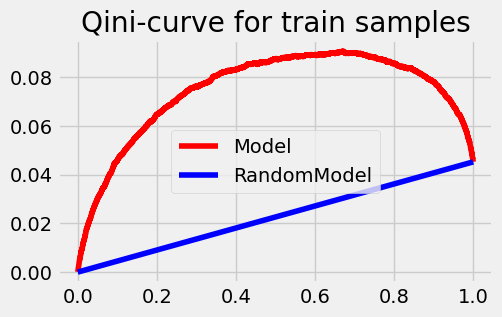

Qini score: 1521.671


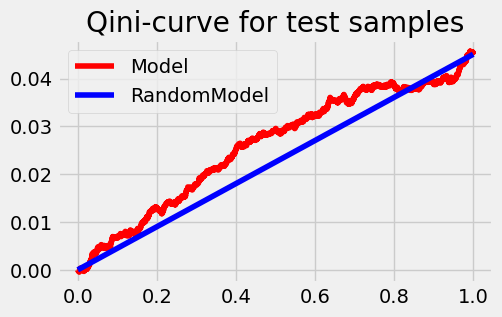

Qini score: 42.978


In [18]:
# Давайте по данным построим T-learner

# Создадим базовый T-learner
t_learner = BaseTClassifier(learner=CatBoostClassifier(random_seed=13, verbose=0))

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
t_learner.fit(X=df_bogo_train[feature_cols],
              treatment=df_bogo_train[treatment_col],
              y=df_bogo_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = t_learner.predict(np.array(df_bogo_train[feature_cols].values.copy()))
df_bogo_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = t_learner.predict(np.array(df_bogo_test[feature_cols].values.copy()))
df_bogo_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_bogo_train, title='train')
qini_df(df_bogo_test, title='test')